# Exploratory analysis of lateral buds

## Frequency tables
- AIM1:create a frequency table per each class length
- AIM2:create a frequency table per each shoot type (prol/syl)
- AIM3: create a frequency table per rank node IN SYLLEPTIC

## Proleptic shoot type
- AIM1: discover where are sylleptic shoots (metamer level)
- AIM2: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per CLASS LENGHT
- AIM3: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per RANK
- AIM4: multiple buds in proleptic 1yo shoots per RANK

data=shoots found in 2021 (Deruta)
Phd=Francesca Grisafi

## Frequency tables

### AIM1: create a frequency table per each class length

In [1]:
%run ../Modify_dataset/IMPORT_DATASET.ipynb

In [2]:
import pandas as pd

def freq_table_class_length(bud_df:pd.DataFrame, class_column: str, fate_column: str,
                           class_new_shoot_col: str, nb_new_shoots_col: str, shoot_id_col: str):
    class_length = pd.DataFrame()

    # Itera per ogni classe unica in `bud`.
    for i in bud_df[class_column].unique():
        class_buds = {}
        class_newshoot = {}
        
        # Calcola la frequenza dei boccioli per ogni 'fate' all'interno della classe.
        for j in bud_df[fate_column].unique():
            class_buds[j] = len(bud_df[(bud_df[class_column] == i) & (bud_df[fate_column] == j)])
        
        # Calcola il numero di nuovi germogli per ogni classe all'interno della classe.
        for q in bud_df[class_column].unique():
            class_newshoot[f"new_shoot_{q}"] = bud_df[(bud_df[class_column] == i) & (bud_df[class_new_shoot_col] == q)][nb_new_shoots_col].sum(skipna=True)
        
        # Aggiunge i risultati al DataFrame `class_length`.
        row_data = {'nb_shoots': bud_df[bud_df[class_column] == i][shoot_id_col].nunique(),
                    'tot_buds_m_v_b_c': len(bud_df[bud_df[class_column] == i][fate_column]),
                    'nb_new_shoots': bud_df[bud_df[class_column] == i][nb_new_shoots_col].sum(),
                    **class_buds,
                    **class_newshoot}
        
        # Crea un DataFrame temporaneo con i risultati per la classe corrente e lo appende a `class_length`.
        temp_df = pd.DataFrame([row_data], index=[i])
        class_length = pd.concat([class_length, temp_df])
    
    return class_length

     nb_shoots  tot_buds_m_v_b_c  nb_new_shoots    V   B   C    M  \
VLo         25               671            442  284  33  71  283   
Lo          28               577            348  212  36  88  241   
Me          25               296            133   92  37  48  119   
Sh          26               133             65   55  18  24   36   

     new_shoot_VLo  new_shoot_Lo  new_shoot_Me  new_shoot_Sh  
VLo              1             4            55           382  
Lo               0             1            23           324  
Me               0             0             7           126  
Sh               0             0             4            61  


In [ ]:
class_length = freq_table_class_length(bud, "class", "fate", "length_newshoots",
                                      "nb_new_shoots", "shoot_ID")
print(class_length)

### AIM2: create a frequency table per each shoot type (prol/syl) 

In [3]:
def freq_table_prol_syl(bud_df:pd.DataFrame, shoot_type_col: str, fate_column: str,
                        nb_new_shoots_col: str, shoot_id_col: str):

    data_list = []
    
    # Itera per ogni classe unica in `bud`
    for i in bud_df[shoot_type_col].unique():
        data = {'shoot_type': i, 'nb_shoots': bud_df[bud_df[shoot_type_col] == i][shoot_id_col].nunique()}
        
        for j in ["M", "V"]:
            data[f'buds_from_{j}'] = len(bud_df[(bud_df[shoot_type_col] == i) & (bud_df[fate_column] == j)])
        
        for q in bud[fate_column].unique():
            data[f'new_shoot_from_{q}'] = bud_df[(bud_df[shoot_type_col] == i) & (bud_df[fate_column] == q)][nb_new_shoots_col].sum(skipna=True)
        
        data[nb_new_shoots_col] = bud_df[bud_df[shoot_type_col] == i][nb_new_shoots_col].sum()
        
        # Aggiunge i dati raccolti alla lista
        data_list.append(data)
    
    # Converti la lista in DataFrame
    shoot_type_summary = pd.DataFrame(data_list)
    
    # Calcola le proporzioni di "bud burst" e "errors"
    shoot_type_summary['bud_burst'] = (shoot_type_summary['new_shoot_from_M'] + shoot_type_summary['new_shoot_from_V']) / (shoot_type_summary['buds_from_M'] + shoot_type_summary['buds_from_V'])
    shoot_type_summary['errors'] = (shoot_type_summary['new_shoot_from_C'] + shoot_type_summary['new_shoot_from_B']) / shoot_type_summary['nb_new_shoots']
    
    return(shoot_type_summary)


shoot_type_summary = freq_table_prol_syl(bud, "shoot_type", "fate",
                                         "nb_new_shoots", "shoot_ID")
print(shoot_type_summary)

  shoot_type  nb_shoots  buds_from_M  buds_from_V  new_shoot_from_V  \
0  PROLEPTIC        104          429          371               281   
1  SYLLEPTIC         88          250          272               165   

   new_shoot_from_B  new_shoot_from_C  new_shoot_from_M  nb_new_shoots  \
0                24                 0               379            684   
1                 0                23               116            304   

   bud_burst    errors  
0   0.825000  0.035088  
1   0.538314  0.075658  


### AIM3: create a frequency table per each rank node IN SYLLEPTIC

In [4]:
import numpy as np

def freq_buds_in_rank_sylleptic(metamer_syl_df: pd.DataFrame, rank_node_col: str,
                                c_col: str, v_col: str, m_col: str, b_col: str) -> pd.DataFrame:
    """
    Calcola la frequenza dei germogli silleptici per ogni rango nodale.

    Parametri:
    - metamer_syl_df (pd.DataFrame): DataFrame contenente i dati sui metameri.
    - rank_node_col (str): Nome della colonna che identifica il rango del nodo.
    - c_col (str): Nome della colonna per i conteggi di germogli 'c'.
    - v_col (str): Nome della colonna per i conteggi di germogli 'v'.
    - m_col (str): Nome della colonna per i conteggi di germogli 'm'.
    - b_col (str): Nome della colonna per i conteggi di germogli 'b'.

    Ritorna:
    pd.DataFrame: DataFrame riepilogativo con le frequenze dei germogli per rango nodale.
    """
    
    nline = len(metamer_syl_df[rank_node_col].unique())
    tab_syl = pd.DataFrame(index=np.arange(1, nline + 1),
                           columns=['rank_node', 'nb_shoots', c_col, v_col, m_col, b_col])

    for q, Q in enumerate(sorted(metamer_syl_df[rank_node_col].unique()), 1):
        subset = metamer_syl_df[metamer_syl_df[rank_node_col] == Q]
        tab_syl.loc[q, 'rank_node'] = Q
        tab_syl.loc[q, 'nb_shoots'] = len(subset)
        tab_syl.loc[q, c_col] = subset[c_col].sum()
        tab_syl.loc[q, v_col] = subset[v_col].sum()
        tab_syl.loc[q, m_col] = subset[m_col].sum()
        tab_syl.loc[q, b_col] = subset[b_col].sum()

    # Aggiungere la somma per ogni colonna e per ogni riga
    tab_syl.loc['sums', [c_col, v_col, m_col, b_col]] = tab_syl[[c_col, v_col, m_col, b_col]].sum()
    tab_syl['sums'] = tab_syl[[c_col, v_col, m_col, b_col]].sum(axis=1)

    #relative frequence
    for col in [c_col, v_col, m_col, b_col]:
        tab_syl[f'%{col.upper()}'] = (tab_syl[col].astype(float) / tab_syl['nb_shoots'].astype(float) * 100).round(2)

    return tab_syl

tab_syl = freq_buds_in_rank_sylleptic(met_sylleptic, 'parent_rank_node', 'c_syl', 'v_syl', 'm_syl', 'b')
print(tab_syl.head())

  rank_node nb_shoots c_syl v_syl m_syl  b sums  %C_SYL  %V_SYL  %M_SYL   %B
1         1         3     3     0     0  0    3   100.0    0.00    0.00  0.0
2         2        11    11     8     9  0   28   100.0   72.73   81.82  0.0
3         3        19    19    21    12  0   52   100.0  110.53   63.16  0.0
4         4        25    25    29    21  0   75   100.0  116.00   84.00  0.0
5         5        46    46    66    69  0  181   100.0  143.48  150.00  0.0


## PROLEPTIC SHOOT TYPE

### AIM1: discover where are sylleptic shoots (metamer level)

In [5]:
import matplotlib.pyplot as plt

print(met_proleptic.columns)

def plot_scatter(df, x_col, y_col, title):
    plt.scatter(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

Index(['tesi', 'unit', 'length', 'unit_2', 'diam', 'class', 'shoot_ID', 'tree',
       'Length(node)', 'rank_node', 'median_distance', 'norm_median_distance',
       'abs_norm_median_distance', 'abs_median_distance', 'sylleptic', 'v',
       'm', 'cl', 'nu', 'b', 'tot_buds_mvb', 'tot_buds_mv', 'shoot_type',
       'nb_new_shoots', 'c_syl', 'v_syl', 'm_syl', 'tot_buds_syl_m_v',
       'tot_buds_m_v_b_c'],
      dtype='object')


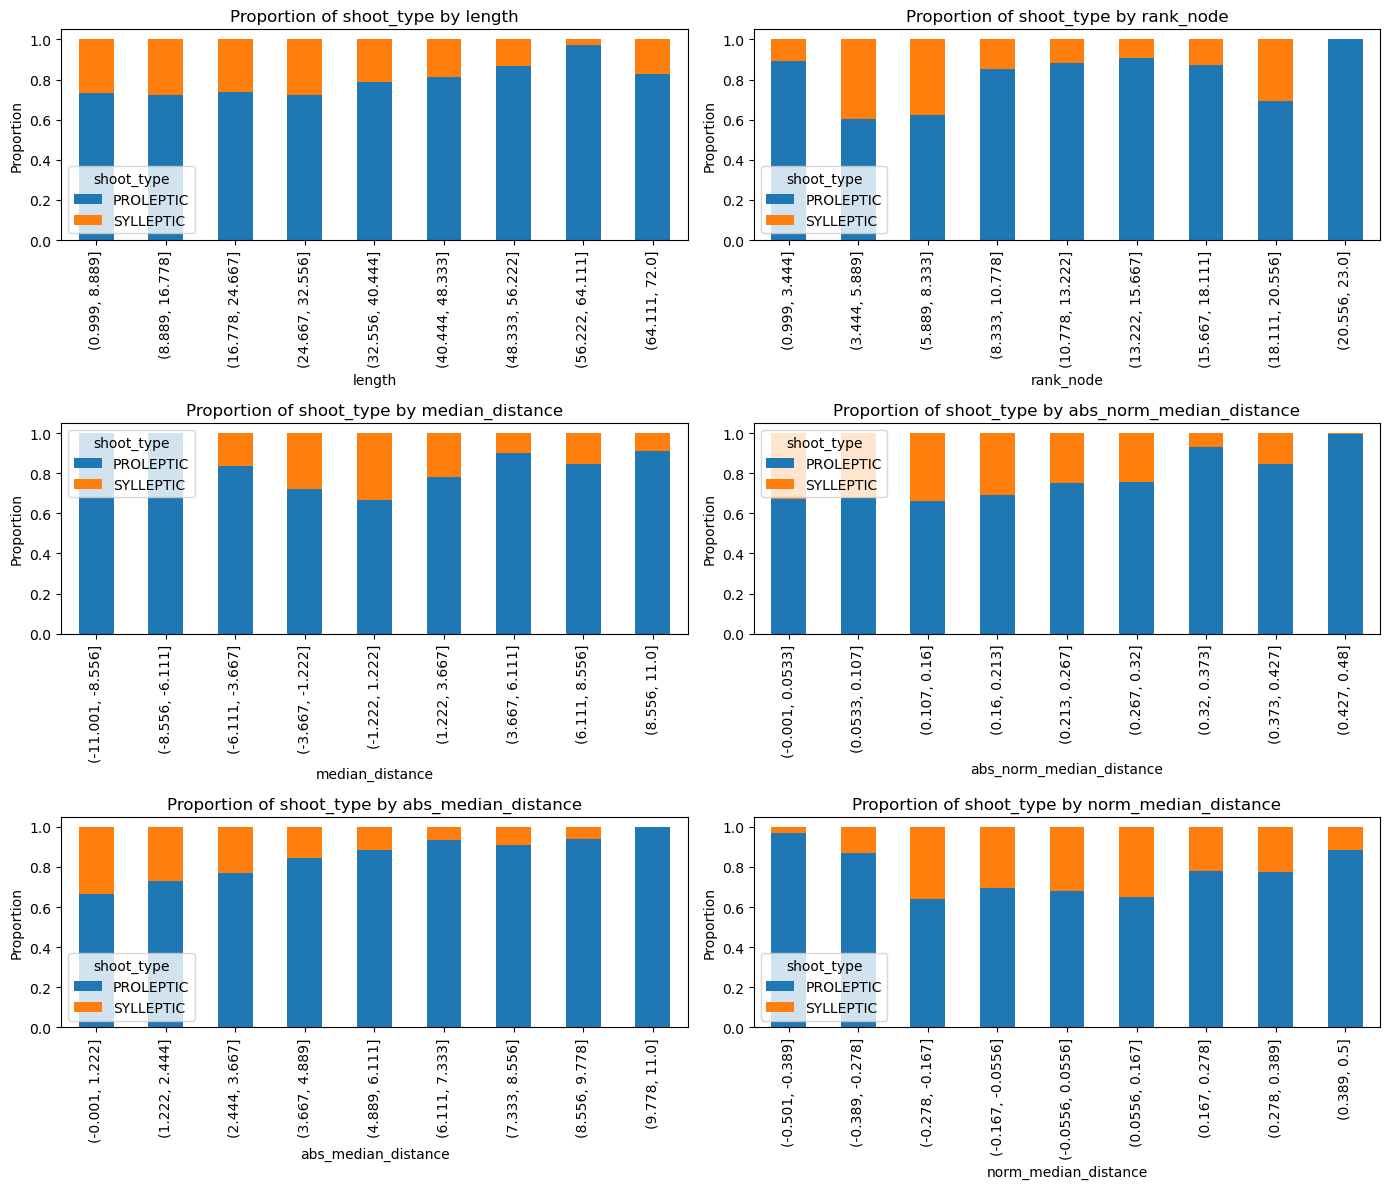

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Supponiamo che met_proleptic sia il DataFrame e che contenga una colonna 'shoot_type' categorica
# e diverse colonne continue come 'length', 'rank_node', ecc.

def plot_proportion(df, x_var, cat_var, ax, num_bins=10):
    # Bin the continuous variable
    bins = np.linspace(df[x_var].min(), df[x_var].max(), num_bins)
    df['binned'] = pd.cut(df[x_var], bins, include_lowest=True)
    
    # Calcola la proporzione per ciascun bin
    proportions = df.groupby(['binned', cat_var], observed=True).size().unstack().fillna(0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    
    # Plot
    proportions.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Proportion of {cat_var} by {x_var}')
    ax.set_xlabel(x_var)
    ax.set_ylabel('Proportion')

# Creazione di subplot per ciascun x_var
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
x_vars = ['length', 'rank_node', 'median_distance', 'abs_norm_median_distance', 'abs_median_distance', 'norm_median_distance']

for ax, x_var in zip(axes.flatten(), x_vars):
    plot_proportion(met_proleptic, x_var, 'shoot_type', ax)

plt.tight_layout()
plt.show()

###  AIM2: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per CLASS LENGHT 

In [7]:
def calculate_class_summary(df, class_col, count_cols):
    # Inizializza liste per raccogliere i dati
    data = {col: [] for col in [class_col] + count_cols}
    data['Total'] = []

    # Aggrega i dati per classe
    for i in df[class_col].unique():
        subset = df[df[class_col] == i]
        data[class_col].append(i)
        for col in count_cols:
            data[col].append(subset[col].sum())
        data['Total'].append(subset[count_cols].sum().sum())

    # Crea un DataFrame dai dati raccolti
    summary_df = pd.DataFrame(data)

    # Calcola le percentuali relative
    for col in count_cols:
        summary_df[f'%{col}'] = (summary_df[col] / summary_df['Total']) * 100

    # Calcola la somma delle colonne e delle righe se necessario
    # Aggiungi ulteriori operazioni qui...

    return summary_df

class_summary = calculate_class_summary(met_proleptic, 'class', ['sylleptic', 'v', 'm', 'b'])
# Define the custom order for 'class'
class_order = ['Sh', 'Me', 'Lo', 'VLo']

# Create a categorical type with the custom order
class_summary['class'] = pd.Categorical(class_summary['class'], categories=class_order, ordered=True)

# Sort the DataFrame by 'class' according to the categorical order
class_summary = class_summary.sort_values('class')
print(class_summary)

  class  sylleptic    v    m   b  Total  %sylleptic         %v         %m  \
3    Sh         24   40   24  18    106   22.641509  37.735849  22.641509   
2    Me         48   44   56  37    185   25.945946  23.783784  30.270270   
1    Lo         88  103  156  36    383   22.976501  26.892950  40.731070   
0   VLo         71  184  193  33    481   14.760915  38.253638  40.124740   

          %b  
3  16.981132  
2  20.000000  
1   9.399478  
0   6.860707  


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

def plot_and_test(data, row_slice, col_slice, obs_col_index, plot_title, xlabel, ylabel, ymax = 100, test = True):
    # Extract frequency matrix and column labels for the plot
    freq = data.iloc[row_slice, col_slice].values
    col_labels = data.columns[col_slice]

    # Create the bar plot
    colors = plt.get_cmap('Set2')
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Create a bar plot, grouped by 'class'
    x = np.arange(len(data.index[row_slice]))  # the label locations
    width = 0.2  # the width of the bars
    
    for i, category in enumerate(col_labels):
        ax.bar(x + i*width, data[category], width, label=category, color=colors(i))
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} by class and category")
    ax.set_xticks(x + width + width/2)
    ax.set_xticklabels(data[xlabel])
    ax.legend(title='Legend')
    plt.ylim(0, ymax)

    if test:
        # Correcting statistical tests approach
        for j in range(freq.shape[1]):
            print(f"\nTesting column: {col_labels[j]}")
            for i in range(freq.shape[0] - 1):
                for k in range(i + 1, freq.shape[0]):
                    # Performing z-test between each pair of groups
                    stat, p_value = proportions_ztest([freq[i, j], freq[k, j]], [data.iloc[i, obs_col_index], data.iloc[k, obs_col_index]])
                    print(f"Comparison between {data.index[i]} and {data.index[k]}: p-value = {p_value}")
    plt.show()


Testing column: %sylleptic
Comparison between 3 and 2: p-value = 0.10640901836553508
Comparison between 3 and 1: p-value = 1.4910812169219537e-06
Comparison between 3 and 0: p-value = 2.966337069860781e-12
Comparison between 2 and 1: p-value = 0.0013981684525640197
Comparison between 2 and 0: p-value = 1.2463579466624618e-07
Comparison between 1 and 0: p-value = 0.03629543161695097

Testing column: %v
Comparison between 3 and 2: p-value = 4.815960233771163e-06
Comparison between 3 and 1: p-value = 1.4858198212051288e-14
Comparison between 3 and 0: p-value = 1.649360574056811e-14
Comparison between 2 and 1: p-value = 0.022255135860656777
Comparison between 2 and 0: p-value = 0.051173398098504616
Comparison between 1 and 0: p-value = 0.6065339160008028

Testing column: %m
Comparison between 3 and 2: p-value = 0.2874834550195694
Comparison between 3 and 1: p-value = 0.0036179724450169813
Comparison between 3 and 0: p-value = 8.633121337358471e-05
Comparison between 2 and 1: p-value = 0.0

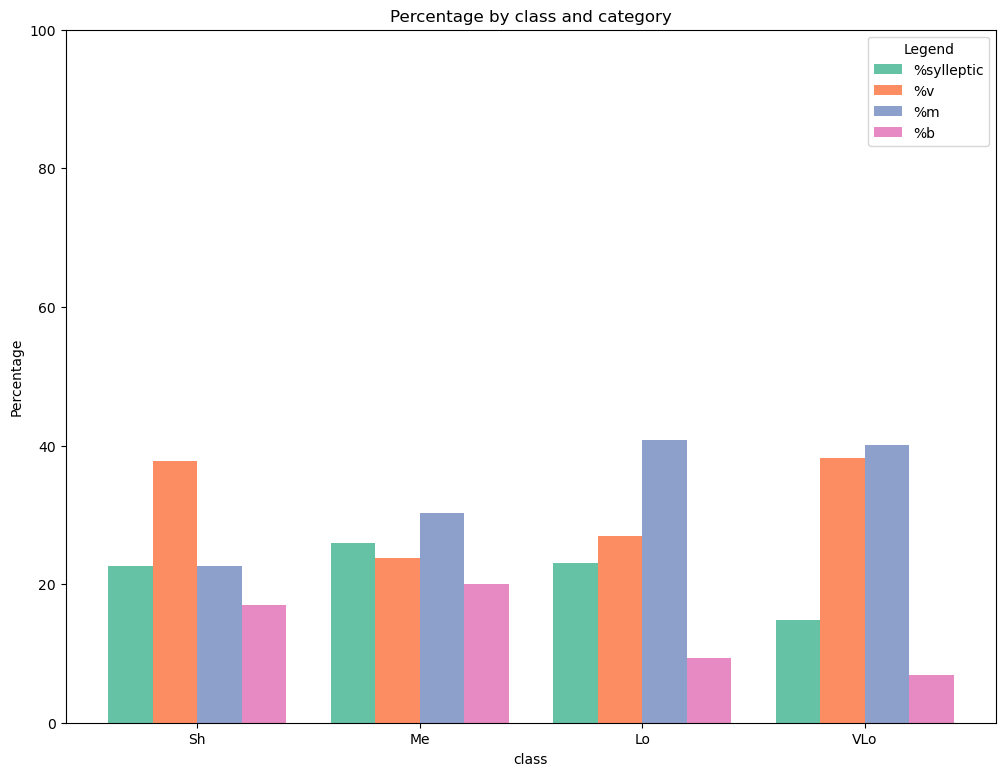

In [9]:
# 2_PRO_freq_obs~class
plot_and_test(class_summary, row_slice=slice(0,4), col_slice=slice(6,10), obs_col_index=5,
               plot_title='Nb Lateral Buds or Shoot Class', xlabel='class', ylabel='Percentage', ymax = 100)

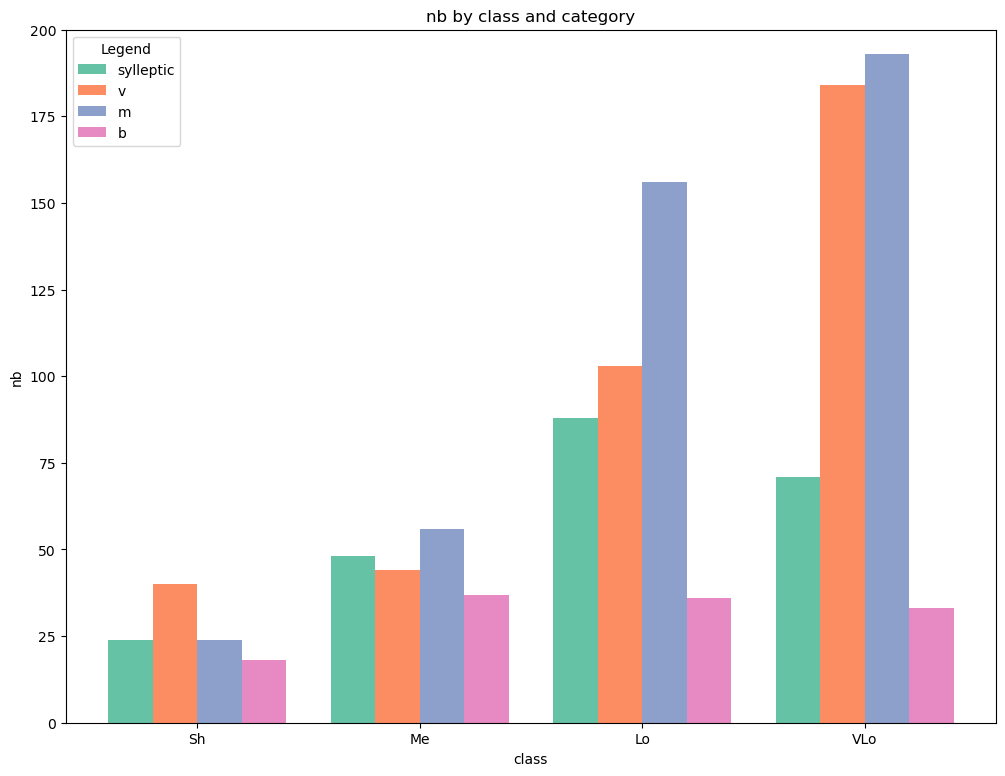

In [10]:
# 2_PRO_nb_obs~class
plot_and_test(class_summary, row_slice=slice(0,4), col_slice=slice(1,5), obs_col_index=5,
               plot_title='Nb Lateral Buds or Shoot Class', xlabel='class', ylabel='nb', ymax = 200, test = False)

In [11]:
# Assuming the 'Total' column should be the sum of the previous four columns
class_summary.loc['Sum'] = class_summary.iloc[:, 1:].sum(axis=0)
print(class_summary)
relative_frequency = class_summary.iloc[4:,1:5] / class_summary.loc['Sum', 'Total']*100
print(relative_frequency)
class_summary.iloc[4:,6:10] = relative_frequency

    class  sylleptic      v      m      b   Total  %sylleptic          %v  \
3      Sh       24.0   40.0   24.0   18.0   106.0   22.641509   37.735849   
2      Me       48.0   44.0   56.0   37.0   185.0   25.945946   23.783784   
1      Lo       88.0  103.0  156.0   36.0   383.0   22.976501   26.892950   
0     VLo       71.0  184.0  193.0   33.0   481.0   14.760915   38.253638   
Sum   NaN      231.0  371.0  429.0  124.0  1155.0   86.324871  126.666221   

             %m         %b  
3     22.641509  16.981132  
2     30.270270  20.000000  
1     40.731070   9.399478  
0     40.124740   6.860707  
Sum  133.767590  53.241317  
     sylleptic          v          m          b
Sum       20.0  32.121212  37.142857  10.735931


C:\Users\franc\AppData\Local\Temp\ipykernel_42392\83787131.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  class_summary.loc['Sum'] = class_summary.iloc[:, 1:].sum(axis=0)


In [12]:
df_plot = class_summary.iloc[4:,6:10]
df_plot = df_plot.T
print(df_plot)

                  Sum
%sylleptic  20.000000
%v          32.121212
%m          37.142857
%b          10.735931


In [13]:
def barplot_annotation(df, xlab, title):
    colors = plt.get_cmap('Set2')
    fig, ax = plt.subplots(figsize=(12, 9))
    x = np.arange(len(df.index))  # the label locations
    width = 0.8  # the width of the bars
    for i, category in enumerate(df.index):
        ax.bar(x[i], df.iloc[i,:], width, label=category, color=colors(i))
        plt.text(x[i], df.iloc[i,:] + 3, f"{round(df.iloc[i,:][0],2)}", ha='center')
    
    ax.set_xlabel(xlab)
    ax.set_ylabel("%")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(df.index.tolist())
    ax.legend(title='Legend')
    plt.ylim(0, 100)
    plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_42392\3710741307.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x[i], df.iloc[i,:] + 3, f"{round(df.iloc[i,:][0],2)}", ha='center')
C:\Users\franc\miniconda3\envs\lpy\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
C:\Users\franc\miniconda3\envs\lpy\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


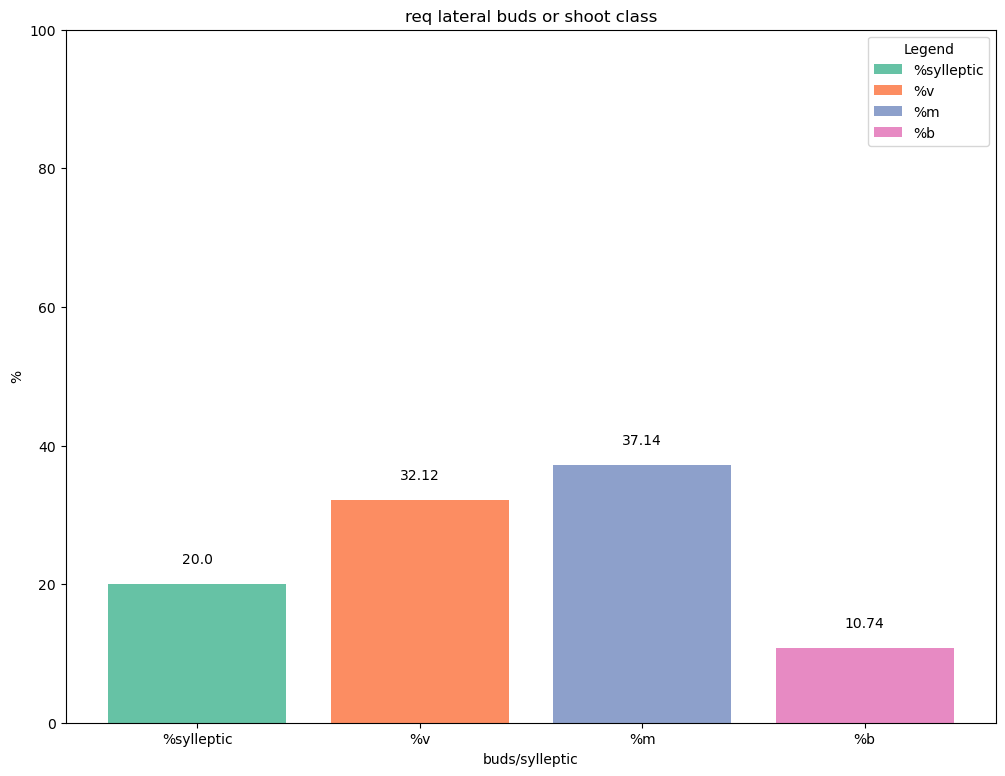

In [14]:
# PRO_nb_obs
barplot_annotation(df_plot, "buds/sylleptic", "req lateral buds or shoot class")

### AIM3: NB of observations (buds + sylleptic shoots) in proleptic 1yo shoots per RANK

In [15]:
def process_rank_data(met_proleptic):
    # Initialize the DataFrame with the required structure
    class_rank = pd.DataFrame(columns=['rank_node', 'nb_shoots', 'sylleptic', 'v', 'm', 'b'])

    # Get unique, sorted ranks
    unique_ranks = sorted(met_proleptic['rank_node'].unique())

    # Loop through each unique rank and perform calculations
    for Q in unique_ranks:
        filtered_data = met_proleptic[met_proleptic['rank_node'] == Q]
        class_rank.loc[Q] = {
            'rank_node': Q,
            'nb_shoots': len(filtered_data['shoot_ID']),
            'sylleptic': filtered_data['sylleptic'].sum(),
            'v': filtered_data['v'].sum(),
            'm': filtered_data['m'].sum(),
            'b': filtered_data['b'].sum()
        }

    # Calculate column sums and add as a new row at the end
    class_rank.loc['sums'] = class_rank.sum(numeric_only=True)

    # Calculate sum of specific columns for each row and store in a new column
    class_rank['sum_obs'] = class_rank[['sylleptic', 'v', 'm', 'b']].sum(axis=1)

    return class_rank

In [16]:
class_rank = process_rank_data(met_proleptic)
class_rank.head()

,rank_node,nb_shoots,sylleptic,v,m,b,sum_obs
1,1,104,3,53,20,28,104
2,2,103,11,39,19,38,107
3,3,99,19,29,21,36,105
4,4,93,25,31,37,15,108
5,5,85,46,22,31,3,102


In [17]:
def calculate_relative_frequencies(class_rank):
    # Assuming columns 3 to 6 in class_rank correspond to 'sylleptic', 'v', 'm', 'b' and the totals are in column 7 (as per your R code)
    # Check the exact DataFrame structure with print(class_rank.columns) and adjust indices accordingly
    indices_mapping = {2: 'sylleptic', 3: 'v', 4: 'm', 5: 'b', 6: 'sum_obs'}  # 0-based indexing in Python

    # Calculate relative frequencies and round to 2 decimal places
    for key, value in indices_mapping.items():
        if key < 6:  # Exclude sum_obs from division operation
            class_rank[f'%{value.upper()}'] = round((class_rank.iloc[:, key] / class_rank['sum_obs']) * 100, 2)

    return class_rank

In [18]:
class_rank = calculate_relative_frequencies(class_rank)
class_rank.head()

,rank_node,nb_shoots,sylleptic,v,m,b,sum_obs,%SYLLEPTIC,%V,%M,%B
1,1,104,3,53,20,28,104,2.88,50.96,19.23,26.92
2,2,103,11,39,19,38,107,10.28,36.45,17.76,35.51
3,3,99,19,29,21,36,105,18.10,27.62,20.00,34.29
4,4,93,25,31,37,15,108,23.15,28.70,34.26,13.89
5,5,85,46,22,31,3,102,45.10,21.57,30.39,2.94


In [19]:
def plot_rank_data(class_rank, start_row=0, end_row=16):
    # Work with a copy to avoid SettingWithCopyWarning when modifying the DataFrame
    class_rank = class_rank.copy()
    colors = plt.get_cmap('Set2')
    
    # Convert 'rank_node' to categorical for consistent plotting
    class_rank['rank_node'] = pd.Categorical(class_rank['rank_node'])

    plt.figure(figsize=(10, 8))  # Set the figure size
    
    # Define markers and colors for the plot
    markers = ['o', 5, 'x', '*']  # Define markers for each plot
    labels = ['%SYLLEPTIC', '%V', '%M', '%B']

    for i, label in enumerate(labels):
        if label in class_rank.columns:
            # Ensure the data slices are handled as arrays for plotting
            max_index = min(end_row, len(class_rank))
            y_data = class_rank[label][start_row:max_index].to_numpy()
            x_data = np.arange(start_row, max_index)  # Ensure x_data aligns with y_data length

            # Plot the data
            plt.plot(x_data, y_data, marker=markers[i], linestyle='-', label=label, markersize=6, color = colors(i))

    # Set x-ticks and labels correctly
    if 'rank_node' in class_rank:
        plt.xticks(np.arange(start_row, end_row), class_rank['rank_node'][start_row:end_row], rotation=45)
    plt.title("Frequency of Buds/Shoots in Proleptic <Own-Rooted> Parentals", fontsize=14)
    plt.xlabel("Rank Nodes", fontsize=12)
    plt.ylabel("%", fontsize=12)
    plt.ylim(0, 100)  # Set y-axis limits
    plt.legend(title="Legend", loc="upper left")
    plt.grid(False)
    plt.show()

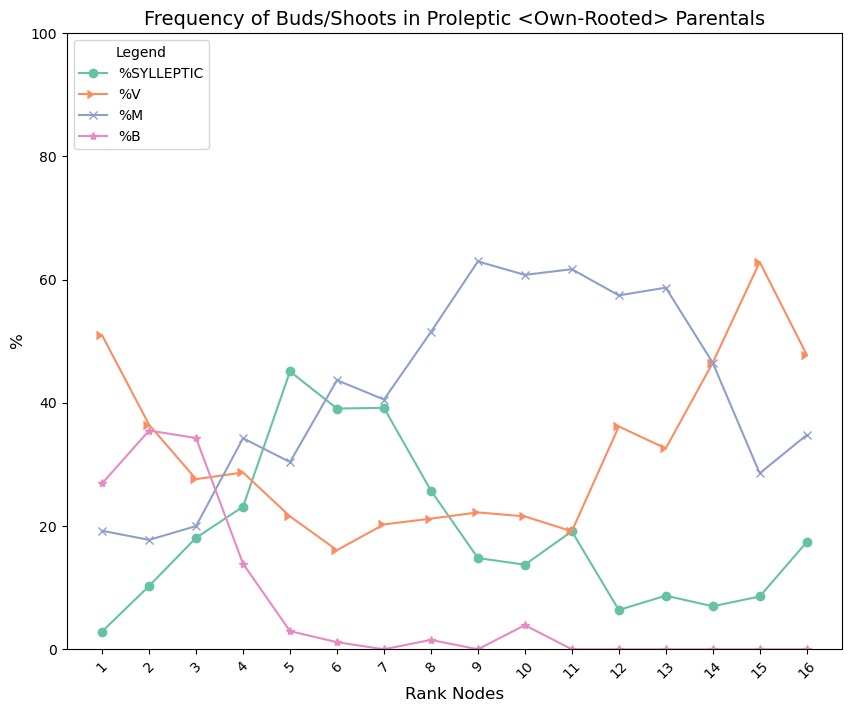

In [20]:
plot_rank_data(class_rank, 0, 16)

### AIM4: SUM of observations (buds + sylleptic shoots) in proleptic

In [21]:
freq_rank = pd.crosstab(index=met['rank_node'], columns=met['tot_buds_m_v_b_c'])

freq_rank.head()

tot_buds_m_v_b_c,1,2,3,4,5,6,7,8,9
rank_node,,,,,,,,,
1,104,0,0,0,0,0,0,0,0
2,92,6,2,1,2,0,0,0,0
3,78,9,7,4,1,0,0,0,0
4,61,12,11,7,1,0,1,0,0
5,33,9,9,22,4,7,0,0,1


In [22]:
from matplotlib.colors import ListedColormap

def plot_stacked_barchart(data, colors, figsize=(12, 9), title="Number of Buds/Sylleptic per Rank in Proleptic Shoots", xlabel="Rank Nodes", ylabel="Number of Multiple Buds/Sylleptic"):

    # Create the bar chart
    plt.figure(figsize=figsize)
    ax = data.plot(kind='bar', stacked=True, color=colors, width=0.6)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Adjust legend position
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0), title="Types of Buds/Sylleptic")

    # Show the plot
    plt.tight_layout()
    plt.show()

C:\Users\franc\AppData\Local\Temp\ipykernel_42392\2762402200.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set3_colors = plt.cm.get_cmap('Set3', num_colors)  # Get colors from Set3


<Figure size 1200x900 with 0 Axes>

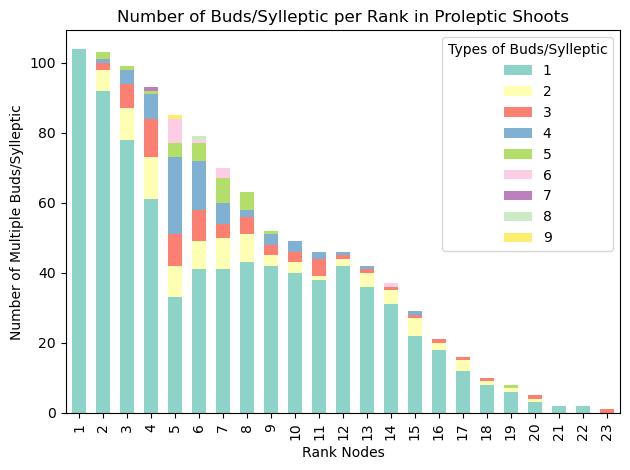

In [23]:
# Create colormap for the bar chart
num_colors = len(freq_rank.columns)
set3_colors = plt.cm.get_cmap('Set3', num_colors)  # Get colors from Set3
colors = set3_colors(np.linspace(0, 1, num_colors))  # Evenly space color pick

plot_stacked_barchart(freq_rank, colors)

In [24]:
rel_freq_rank = (freq_rank.div(freq_rank.sum(axis=1), axis=0) * 100).fillna(0)
rel_freq_rank.head()

tot_buds_m_v_b_c,1,2,3,4,5,6,7,8,9
rank_node,,,,,,,,,
1,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,89.320388,5.825243,1.941748,0.970874,1.941748,0.000000,0.000000,0.0,0.000000
3,78.787879,9.090909,7.070707,4.040404,1.010101,0.000000,0.000000,0.0,0.000000
4,65.591398,12.903226,11.827957,7.526882,1.075269,0.000000,1.075269,0.0,0.000000
5,38.823529,10.588235,10.588235,25.882353,4.705882,8.235294,0.000000,0.0,1.176471


<Figure size 1200x900 with 0 Axes>

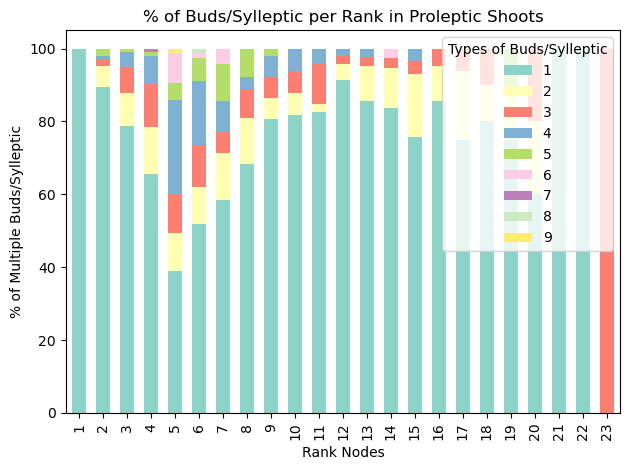

In [25]:
plot_stacked_barchart(rel_freq_rank,colors,
                      title="% of Buds/Sylleptic per Rank in Proleptic Shoots", xlabel="Rank Nodes", ylabel="% of Multiple Buds/Sylleptic")

In [26]:
def process_and_tabulate(df, columns):
    # Transform each specified column
    for col in columns:
        df[col] = df[col].apply(lambda x: '+'.join([col] * x) if x > 0 else np.nan)

    # Merge transformed columns into a single column
    df['merge'] = df[columns].apply(lambda x: '+'.join(x.dropna()), axis=1)

    # Create a frequency table
    frequency_table = pd.crosstab(df['rank_node'], df['merge'])

    return frequency_table

In [27]:
tot = ["sylleptic", "v", "m", "b"]
frequency_table = process_and_tabulate(met_proleptic, tot)

In [28]:
print(frequency_table.head())  # You can adjust the number of lines as needed

merge       b   m  m+m  m+m+m+m  sylleptic   v  v+m  v+m+m  v+m+m+m  v+v  \
rank_node                                                                  
1          28  20    0        0          3  53    0      0        0    0   
2          38  17    0        0         11  35    0      0        0    1   
3          36  18    0        0         19  21    2      0        0    2   
4          15  24    2        0         25  19    3      1        1    1   
5           3  19    0        0         46  10    2      1        1    2   

merge      v+v+m  v+v+m+m  v+v+v  v+v+v+v+m+m+m+m+m  
rank_node                                            
1              0        0      0                  0  
2              0        1      0                  0  
3              1        0      0                  0  
4              1        0      1                  0  
5              0        0      0                  1  


<Figure size 1200x900 with 0 Axes>

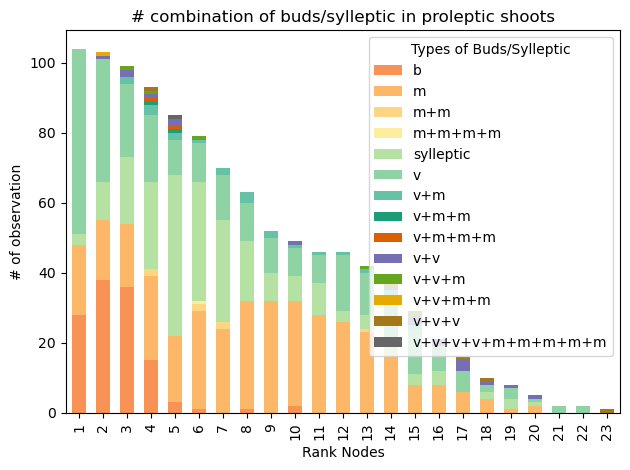

In [29]:
# Define custom colors by combining colors from different colormaps
spectral_colors = plt.get_cmap('Spectral')(np.linspace(0.2, 0.8, 11))  # Adjusted to get 11 colors and sliced
dark2_colors = plt.get_cmap('Dark2')(np.linspace(0, 1, 7))
# Custom selection and combination of colors from both palettes
colors = np.concatenate((spectral_colors[1:5], spectral_colors[8:11], dark2_colors[:7]))

plot_stacked_barchart(frequency_table,colors,
                      title="# combination of buds/sylleptic in proleptic shoots", xlabel="Rank Nodes", ylabel="# of observation")

In [30]:
contingency_table = pd.crosstab(met_proleptic['rank_node'], met_proleptic['merge'])

# Step 2: Convert the counts to relative frequencies (percentages)
# Normalize row-wise by dividing each row by its sum and then multiply by 100
relative_frequencies = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

relative_frequencies.head()

merge,b,m,m+m,m+m+m+m,sylleptic,v,v+m,v+m+m,v+m+m+m,v+v,v+v+m,v+v+m+m,v+v+v,v+v+v+v+m+m+m+m+m
rank_node,,,,,,,,,,,,,,
1,26.923077,19.230769,0.000000,0.0,2.884615,50.961538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,36.893204,16.504854,0.000000,0.0,10.679612,33.980583,0.000000,0.000000,0.000000,0.970874,0.000000,0.970874,0.000000,0.000000
3,36.363636,18.181818,0.000000,0.0,19.191919,21.212121,2.020202,0.000000,0.000000,2.020202,1.010101,0.000000,0.000000,0.000000
4,16.129032,25.806452,2.150538,0.0,26.881720,20.430108,3.225806,1.075269,1.075269,1.075269,1.075269,0.000000,1.075269,0.000000
5,3.529412,22.352941,0.000000,0.0,54.117647,11.764706,2.352941,1.176471,1.176471,2.352941,0.000000,0.000000,0.000000,1.176471


<Figure size 1200x900 with 0 Axes>

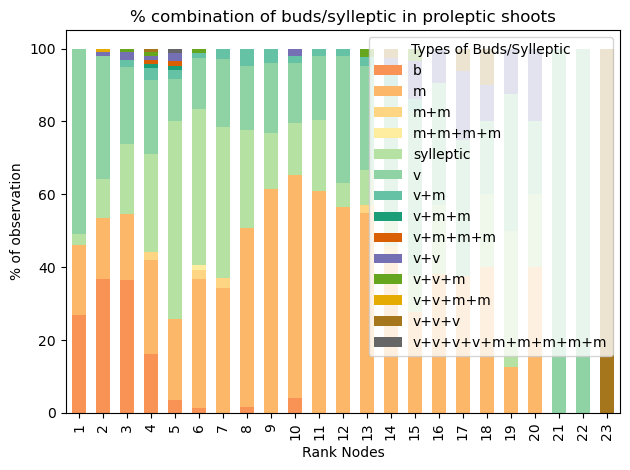

In [32]:
plot_stacked_barchart(relative_frequencies,colors,
                      title="% combination of buds/sylleptic in proleptic shoots", xlabel="Rank Nodes", ylabel="% of observation")

### AIM5: how many m,v,b are per node in proleptic shoots

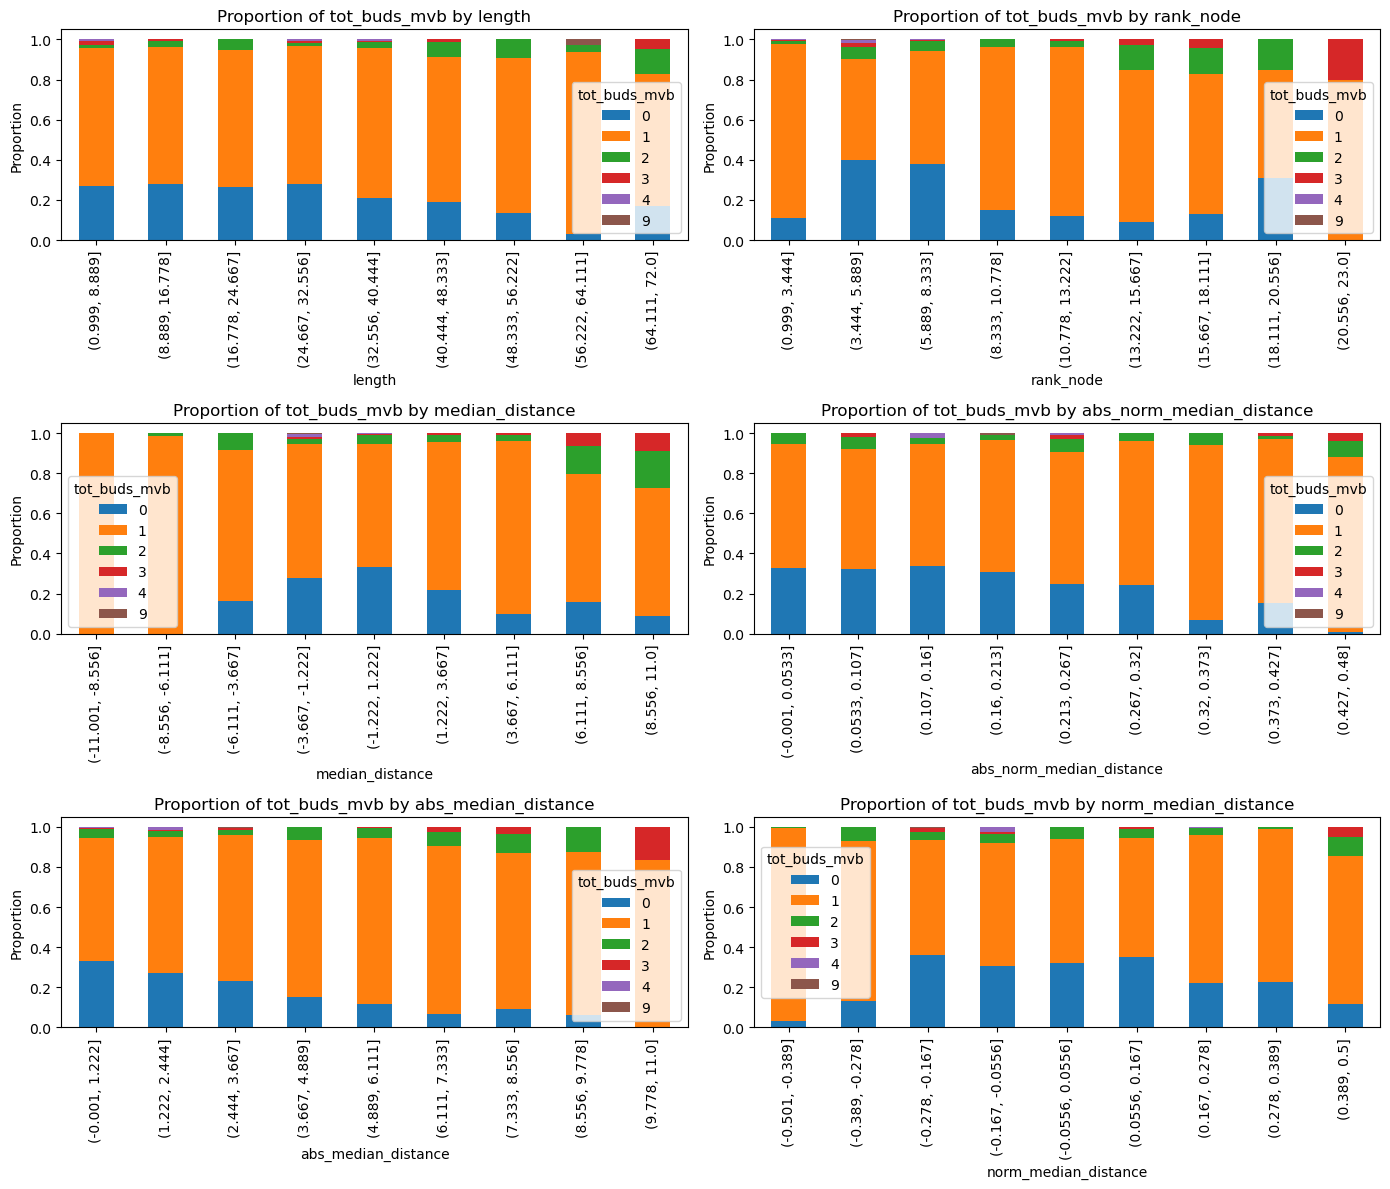

In [33]:
# Creazione di subplot per ciascun x_var
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
x_vars = ['length', 'rank_node', 'median_distance', 'abs_norm_median_distance', 'abs_median_distance', 'norm_median_distance']

for ax, x_var in zip(axes.flatten(), x_vars):
    plot_proportion(met_proleptic, x_var, 'tot_buds_mvb', ax)

plt.tight_layout()
plt.show()

### AIM6: Proportion of buds (m+b+v) in proleptic 1yo shoots

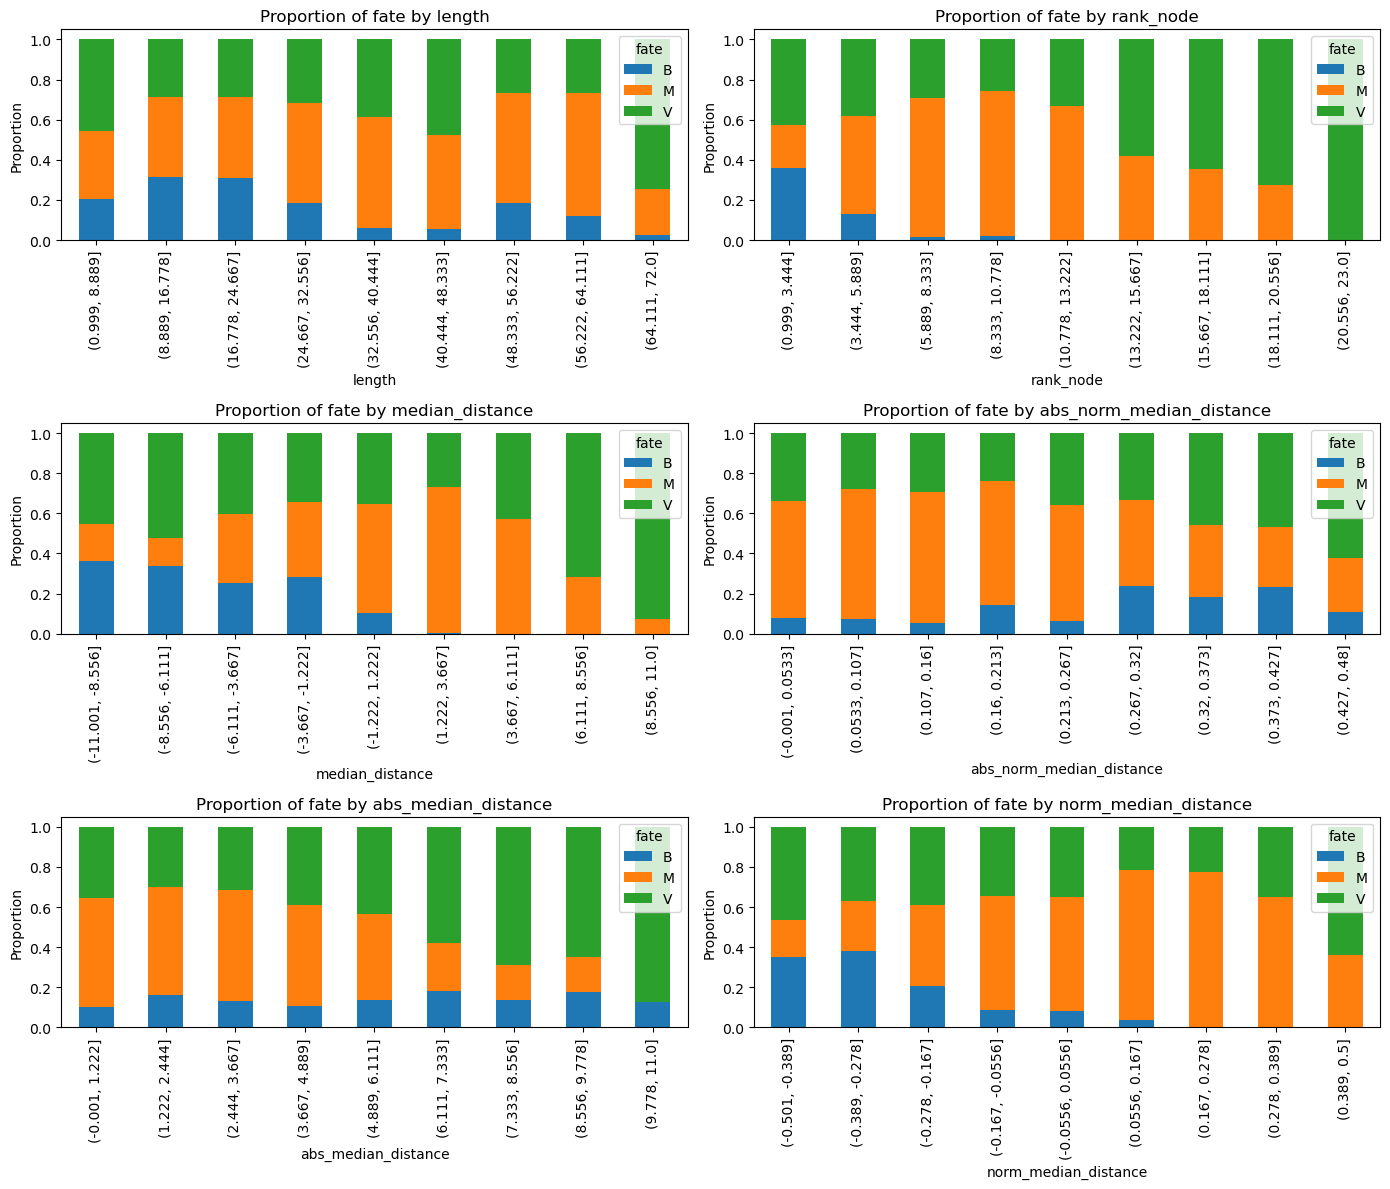

In [34]:
# Creazione di subplot per ciascun x_var
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
x_vars = ['length', 'rank_node', 'median_distance', 'abs_norm_median_distance', 'abs_median_distance', 'norm_median_distance']

for ax, x_var in zip(axes.flatten(), x_vars):
    plot_proportion(bud_proleptic, x_var, 'fate', ax)

plt.tight_layout()
plt.show()

### AIM7: Proportion of buds that sprout into shoots

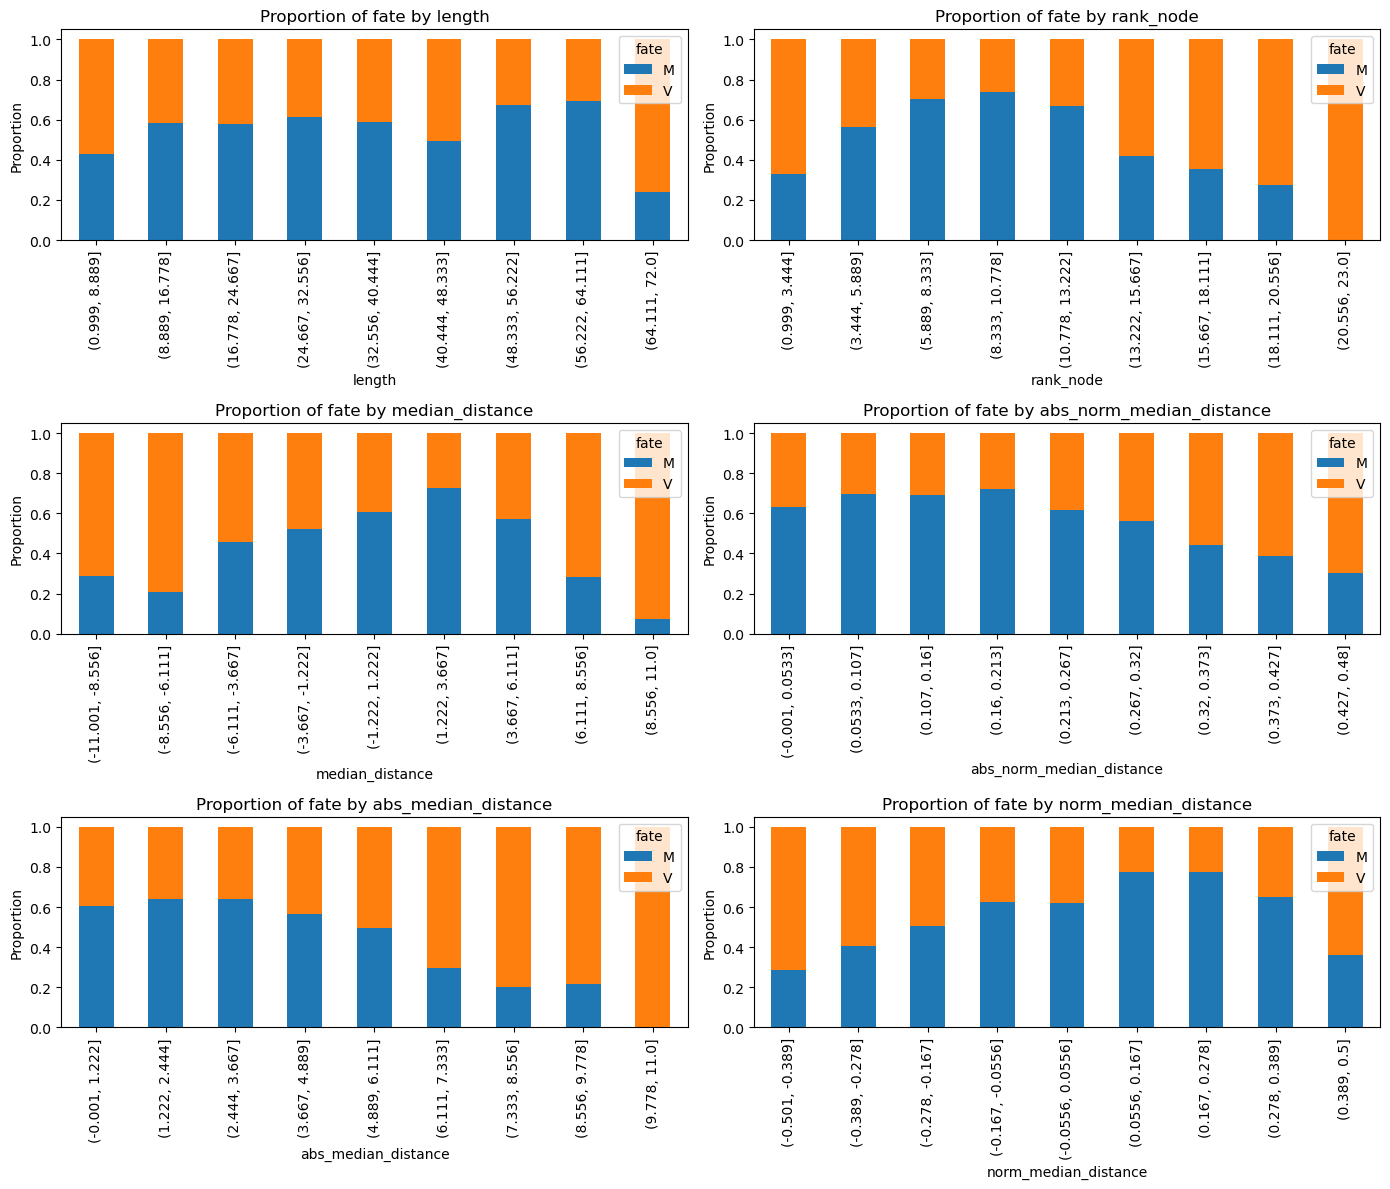

In [35]:
# Creazione di subplot per ciascun x_var
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
x_vars = ['length', 'rank_node', 'median_distance', 'abs_norm_median_distance', 'abs_median_distance', 'norm_median_distance']

for ax, x_var in zip(axes.flatten(), x_vars):
    plot_proportion(MV_bud_PRO, x_var, 'fate', ax)

plt.tight_layout()
plt.show()

In [72]:
contingency_table = pd.crosstab(index=[MV_bud_PRO['rank_node'], MV_bud_PRO['fate']], columns=MV_bud_PRO['nb_new_shoots'])

# Filter to get rows where fate is 'M'
from_M = contingency_table.xs('M', level='fate')
from_V = contingency_table.xs('V', level='fate')

# Calculate relative frequencies per rank node for each fate
from_M_freq = from_M.div(from_M.sum(axis=1), axis=0)
from_V_freq = from_V.div(from_V.sum(axis=1), axis=0)

In [77]:
from_M_freq = from_M_freq[1]  # Extract the column for nb_new_shoots=1
from_V_freq = from_V_freq[1]  # Extract the column for nb_new_shoots=1

In [79]:
# Combine the frequencies into a single DataFrame
from_MV_freq = pd.DataFrame({'V': from_V_freq, 'M': from_M_freq})

# Reset index to make 'rank_node' and 'nb_new_shoots' regular columns
from_MV_freq.reset_index(inplace=True)

# Print the resulting frequency matrix
print(from_MV_freq.head())

   rank_node         V    M
0          1  0.415094  0.6
1          2  0.717949  0.6
2          3  0.758621  0.6
3          4  0.741935  0.6
4          5  0.681818  0.6


In [80]:
def plot_bud_development(df, title="Proportion of Proleptic Buds Developed",
                         x_label="Rank Nodes", y_label="%", figsize=(10, 6)):
    # Define a custom color palette
    colors = ['#66c2a5', '#fc8d62']  # Example colors, adjust if necessary

    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plotting vegetative buds
    plt.plot(df.index[:16], df['V'][:16], 'o-', color=colors[0], 
             markersize=7, linewidth=2, label='Vegetative buds')

    # Plotting mixed buds
    plt.plot(df.index[:16], df['M'][:16], 'o-', color=colors[1], 
             markersize=7, linewidth=2, label='Mixed buds')

    # Adding plot titles and labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 100)

    # Adding a legend
    plt.legend(loc='upper right', frameon=True, title='Bud Type')

    # Show the plot
    plt.show()

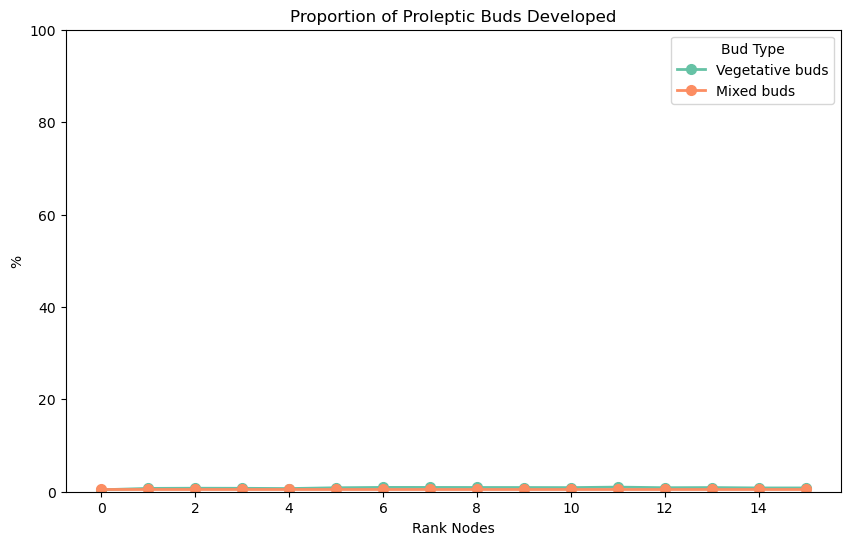

In [81]:
plot_bud_development(from_MV_freq)